# FIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

1. Generate **synthetic SAOS data** from NB01 calibrated parameters
2. Analyze **G' and G''** frequency dependence with fractional memory
3. Understand how **alpha_structure** modifies linear viscoelastic response
4. Fit FIKH to oscillatory data and infer fractional order
5. Compare FIKH moduli predictions across alpha values

## Prerequisites

- **NB01**: FIKH Flow Curve (provides calibrated parameters)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~5-8 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~20-30 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_fikh_parameters,
    generate_synthetic_saos,
    save_fikh_results,
    set_model_parameters,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Fractional SAOS Response

In small-amplitude oscillatory shear, the complex modulus $G^* = G' + iG''$ characterizes linear viscoelastic behavior.

### Classical Maxwell Element
$$
G'(\omega) = G \frac{(\omega\tau)^2}{1 + (\omega\tau)^2}, \quad
G''(\omega) = G \frac{\omega\tau}{1 + (\omega\tau)^2}
$$

### Fractional Maxwell Element
The fractional order $\alpha$ modifies the frequency dependence:
- **Low frequency**: $G' \sim \omega^{2\alpha}$, $G'' \sim \omega^\alpha$
- **High frequency**: Approaches plateau modulus

### Physical Interpretation
- **Lower alpha**: Broader relaxation spectrum, gradual transition
- **Higher alpha**: Sharper crossover (classical Maxwell behavior)

## 3. Load Calibrated Parameters

In [3]:
# Try to load parameters from NB01
try:
    calibrated_params = load_fikh_parameters("fikh", "flow_curve")
    print("Loaded calibrated parameters from NB01:")
    for name, val in calibrated_params.items():
        print(f"  {name:15s} = {val:.4g}")
except FileNotFoundError:
    print("NB01 parameters not found. Using defaults.")
    calibrated_params = None

Loaded calibrated parameters from NB01:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


In [4]:
# Create model and set parameters
model = FIKH(include_thermal=False, alpha_structure=0.7)

if calibrated_params is not None:
    set_model_parameters(model, calibrated_params)

param_names = get_fikh_param_names(include_thermal=False)
print(f"\nModel parameters:")
for name in param_names:
    print(f"  {name:15s} = {model.parameters.get_value(name):.4g}")


Model parameters:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


## 4. Generate Synthetic SAOS Data

In [5]:
# Generate synthetic SAOS data with 3% noise
# Use fewer frequency points for faster execution
OMEGA_RANGE = (0.1, 10.0)  # Narrower range
N_POINTS = 15  # Fewer points for faster fitting
NOISE_LEVEL = 0.03

omega_data, G_prime_data, G_double_prime_data = generate_synthetic_saos(
    model,
    omega_range=OMEGA_RANGE,
    n_points=N_POINTS,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Generated synthetic SAOS data:")
print(f"  Frequency range: [{omega_data.min():.4f}, {omega_data.max():.2f}] rad/s")
print(f"  G' range: [{G_prime_data.min():.4g}, {G_prime_data.max():.4g}] Pa")
print(f"  G'' range: [{G_double_prime_data.min():.4g}, {G_double_prime_data.max():.4g}] Pa")
print(f"  Noise level: {NOISE_LEVEL*100:.0f}%")

Generated synthetic SAOS data:
  Frequency range: [0.1000, 10.00] rad/s
  G' range: [902.2, 990.8] Pa
  G'' range: [7.655, 12.45] Pa
  Noise level: 3%


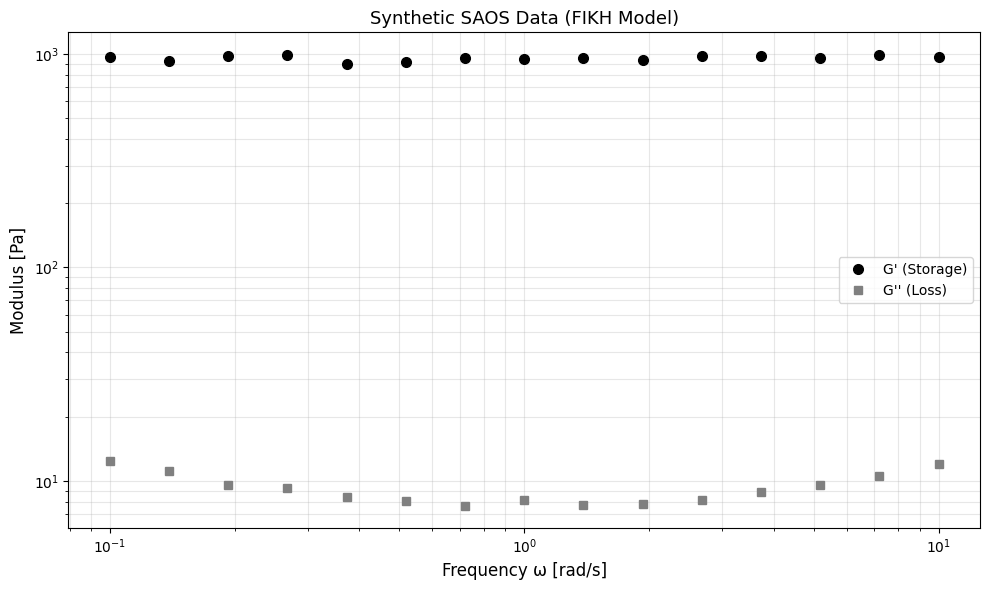

In [6]:
# Plot synthetic SAOS data
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(omega_data, G_prime_data, "ko", markersize=7, label="G' (Storage)")
ax.loglog(omega_data, G_double_prime_data, "s", color="gray", markersize=6, label="G'' (Loss)")

ax.set_xlabel("Frequency ω [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("Synthetic SAOS Data (FIKH Model)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Effect on SAOS

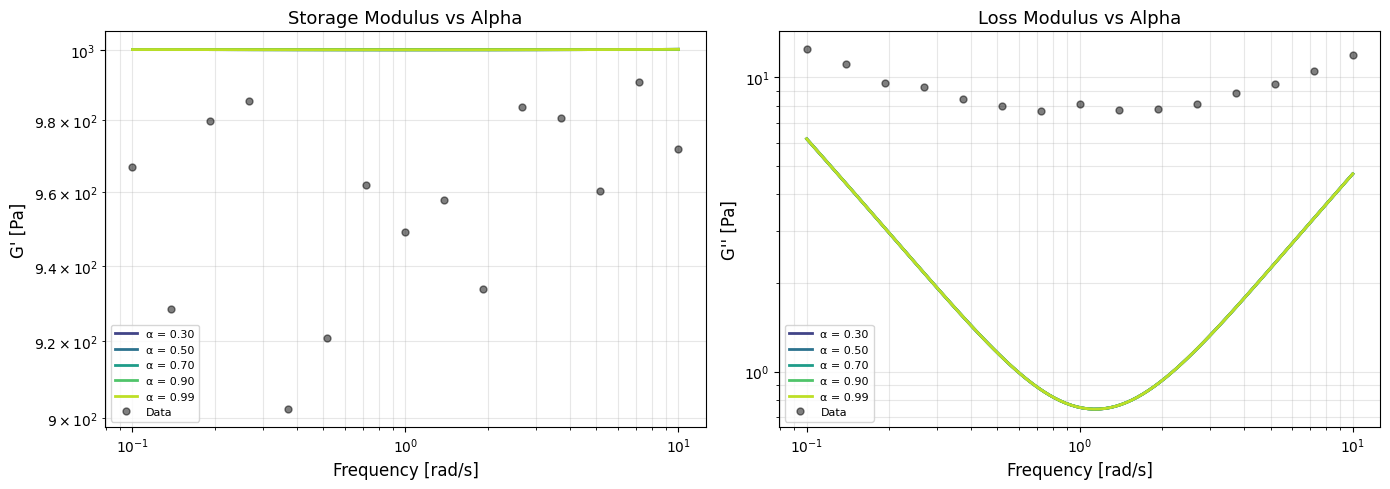

In [7]:
# Compare SAOS response for different alpha values
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]
omega_fine = np.logspace(np.log10(OMEGA_RANGE[0]), np.log10(OMEGA_RANGE[1]), 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(alpha_values)))

original_alpha = model.parameters.get_value("alpha_structure")

for alpha, color in zip(alpha_values, colors):
    model.parameters.set_value("alpha_structure", alpha)
    
    G_star = model.predict_oscillation(omega_fine, gamma_0=0.001, n_cycles=5)
    G_star = np.asarray(G_star)
    G_p = np.real(G_star)
    G_pp = np.imag(G_star)
    
    ax1.loglog(omega_fine, np.maximum(G_p, 1e-10), "-", color=color, lw=2, label=f"α = {alpha:.2f}")
    ax2.loglog(omega_fine, np.maximum(G_pp, 1e-10), "-", color=color, lw=2, label=f"α = {alpha:.2f}")

model.parameters.set_value("alpha_structure", original_alpha)

# Add data points
ax1.loglog(omega_data, G_prime_data, "ko", markersize=5, alpha=0.5, label="Data")
ax2.loglog(omega_data, G_double_prime_data, "ko", markersize=5, alpha=0.5, label="Data")

ax1.set_xlabel("Frequency [rad/s]", fontsize=12)
ax1.set_ylabel("G' [Pa]", fontsize=12)
ax1.set_title("Storage Modulus vs Alpha", fontsize=13)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("Frequency [rad/s]", fontsize=12)
ax2.set_ylabel("G'' [Pa]", fontsize=12)
ax2.set_title("Loss Modulus vs Alpha", fontsize=13)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. NLSQ Fitting

In [8]:
# Fit to SAOS data (complex modulus)
# Combine G' and G'' into complex array for fitting
G_star_data = G_prime_data + 1j * G_double_prime_data

model_fit = FIKH(include_thermal=False, alpha_structure=0.5)

# Use fewer cycles for faster fitting
t0 = time.time()
model_fit.fit(omega_data, np.abs(G_star_data), test_mode="oscillation", 
              gamma_0=0.001, n_cycles=3, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model_fit.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

NLSQ fit time: 1.15 s

Fitted parameters:
  G               = 966.6
  eta             = 5.046e+08
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  alpha_structure = 0.5
  eta_inf         = 0.1297
  mu_p            = 0.001


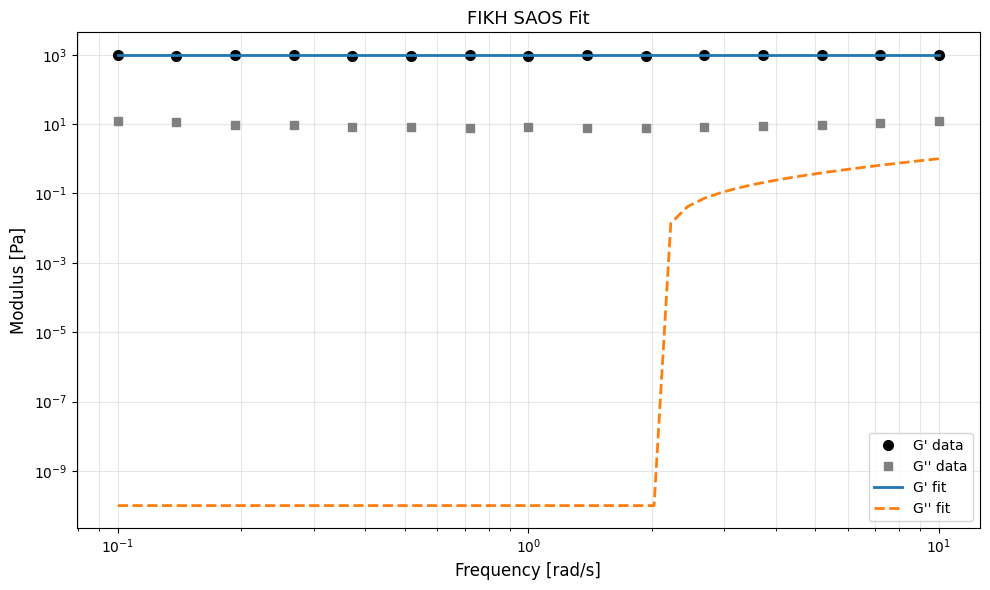

In [9]:
# Plot SAOS fit
omega_fine = np.logspace(np.log10(OMEGA_RANGE[0]), np.log10(OMEGA_RANGE[1]), 50)
G_star_pred = model_fit.predict_oscillation(omega_fine, gamma_0=0.001, n_cycles=3)
G_star_pred = np.asarray(G_star_pred)
G_prime_pred = np.real(G_star_pred)
G_double_prime_pred = np.imag(G_star_pred)

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(omega_data, G_prime_data, "ko", markersize=7, label="G' data")
ax.loglog(omega_data, G_double_prime_data, "s", color="gray", markersize=6, label="G'' data")
ax.loglog(omega_fine, np.maximum(G_prime_pred, 1e-10), "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, np.maximum(G_double_prime_pred, 1e-10), "--", lw=2, color="C1", label="G'' fit")

ax.set_xlabel("Frequency [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("FIKH SAOS Fit", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Bayesian Inference (Optional - Slow)

**Note**: SAOS Bayesian inference is computationally expensive because each likelihood evaluation requires running time-domain simulations at every frequency. The cells below are optional and may take 10+ minutes to complete. For practical workflows, consider:

1. Using NLSQ for quick parameter estimation (as shown above)
2. Running Bayesian inference overnight or on a cluster
3. Using fewer frequency points (5-10 instead of 40)

In [10]:
# Bayesian inference (OPTIONAL - may take 10+ minutes)
# Skip this cell for quick demos; uncomment to run full Bayesian inference

SKIP_BAYESIAN = True  # Set to False to run Bayesian inference

if not SKIP_BAYESIAN:
    initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}
    
    NUM_WARMUP = 100
    NUM_SAMPLES = 200
    NUM_CHAINS = 1
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model_fit.fit_bayesian(
        omega_data,
        np.abs(G_star_data),
        test_mode="oscillation",
        gamma_0=0.001,
        n_cycles=3,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
else:
    print("Skipping Bayesian inference (SKIP_BAYESIAN=True)")
    print("Set SKIP_BAYESIAN=False to run full inference (may take 10+ minutes)")
    result = None

Skipping Bayesian inference (SKIP_BAYESIAN=True)
Set SKIP_BAYESIAN=False to run full inference (may take 10+ minutes)


In [11]:
# Convergence (only if Bayesian was run)
if result is not None:
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Bayesian inference was skipped. No convergence diagnostics available.")

Bayesian inference was skipped. No convergence diagnostics available.


In [12]:
# Alpha posterior (only if Bayesian was run)
if result is not None:
    posterior = result.posterior_samples
    alpha_samples = posterior["alpha_structure"]
    alpha_median = np.median(alpha_samples)
    alpha_lo, alpha_hi = np.percentile(alpha_samples, [2.5, 97.5])
    true_alpha = model.parameters.get_value("alpha_structure")
    
    print("\nFractional Order Recovery:")
    print("=" * 50)
    print(f"  True alpha:      {true_alpha:.3f}")
    print(f"  Posterior:       {alpha_median:.3f} [{alpha_lo:.3f}, {alpha_hi:.3f}]")
else:
    print("Bayesian inference was skipped. No posterior analysis available.")

Bayesian inference was skipped. No posterior analysis available.


In [13]:
# Parameter comparison (only if Bayesian was run)
if result is not None:
    posterior = result.posterior_samples
    print_parameter_comparison(model_fit, posterior, param_names)
else:
    print("Bayesian inference was skipped. Showing NLSQ parameters only:")
    for name in param_names:
        val = model_fit.parameters.get_value(name)
        print(f"  {name:15s} = {val:.4g}")

Bayesian inference was skipped. Showing NLSQ parameters only:
  G               = 966.6
  eta             = 5.046e+08
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  alpha_structure = 0.5
  eta_inf         = 0.1297
  mu_p            = 0.001


## 8. Save Results

In [14]:
if result is not None:
    save_fikh_results(model_fit, result, "fikh", "saos", param_names)
    print("\nResults saved.")
else:
    print("Bayesian results not saved (inference was skipped).")

Bayesian results not saved (inference was skipped).


## Key Takeaways

1. **SAOS reveals linear viscoelastic response** with G' and G'' vs frequency
2. **Lower alpha** → broader relaxation spectrum, gradual crossover
3. **Higher alpha** → sharper Maxwell-like crossover
4. **SAOS constrains G and tau** well, alpha moderately
5. **Combined with relaxation data** provides better alpha estimation

### Next Steps

- **NB06**: LAOS (large amplitude, nonlinear response)